# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

## Load sequence parameters

In [2]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

In [6]:
nUS = num_spokes
iS = matrix_size[2]//2

print(f"Number of spokes: {nUS}")
print(f"Center slice number: {iS}")

Number of spokes: 64
Center slice number: 4


In [7]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [8]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [9]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_4_64.h5


In [10]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 4 of 8.


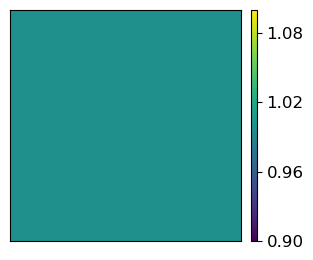

In [11]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

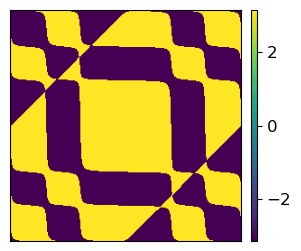

In [12]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [13]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [14]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

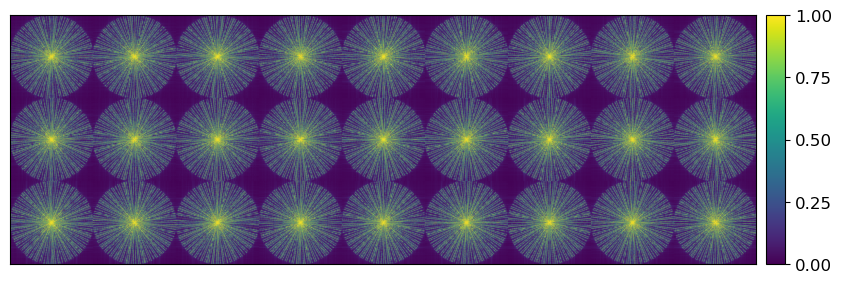

In [15]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

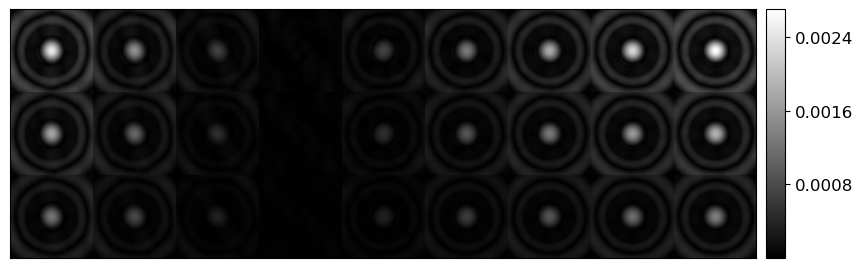

In [16]:
MultiPlotter(
    np.abs(AHd[:, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

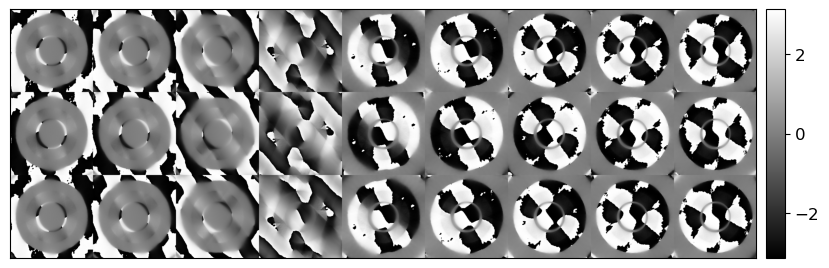

In [17]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [18]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [19]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 3.58E-02 Dual Res: 3.58E-02 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 2.98E-02 Dual Res: 5.61E-03 Rel Res: 9.60E-01:   7%|▋         | 2/30 [00:02<00:35,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.245e+00


[ADMM] Iter: 02 Prim Res: 2.06E-02 Dual Res: 1.11E-02 Rel Res: 6.87E-01:  10%|█         | 3/30 [00:03<00:33,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.253e+00


[ADMM] Iter: 03 Prim Res: 1.32E-02 Dual Res: 1.16E-02 Rel Res: 3.79E-01:  13%|█▎        | 4/30 [00:05<00:32,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.251e+00


[ADMM] Iter: 04 Prim Res: 1.10E-02 Dual Res: 7.62E-03 Rel Res: 2.71E-01:  17%|█▋        | 5/30 [00:06<00:31,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.246e+00


[ADMM] Iter: 05 Prim Res: 1.02E-02 Dual Res: 2.97E-03 Rel Res: 2.34E-01:  20%|██        | 6/30 [00:07<00:29,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.243e+00


[ADMM] Iter: 06 Prim Res: 8.82E-03 Dual Res: 1.28E-03 Rel Res: 2.08E-01:  23%|██▎       | 7/30 [00:08<00:28,  1.24s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.237e+00


[ADMM] Iter: 07 Prim Res: 7.57E-03 Dual Res: 2.36E-03 Rel Res: 1.88E-01:  27%|██▋       | 8/30 [00:09<00:27,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.257e+00


[ADMM] Iter: 08 Prim Res: 6.62E-03 Dual Res: 2.32E-03 Rel Res: 1.75E-01:  30%|███       | 9/30 [00:11<00:26,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.252e+00


[ADMM] Iter: 09 Prim Res: 6.06E-03 Dual Res: 1.58E-03 Rel Res: 1.66E-01:  33%|███▎      | 10/30 [00:12<00:25,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.254e+00


[ADMM] Iter: 10 Prim Res: 5.55E-03 Dual Res: 8.26E-04 Rel Res: 1.54E-01:  37%|███▋      | 11/30 [00:13<00:23,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.244e+00


[ADMM] Iter: 11 Prim Res: 4.98E-03 Dual Res: 6.33E-04 Rel Res: 1.39E-01:  40%|████      | 12/30 [00:14<00:22,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.254e+00


[ADMM] Iter: 12 Prim Res: 4.52E-03 Dual Res: 6.77E-04 Rel Res: 1.26E-01:  43%|████▎     | 13/30 [00:16<00:21,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.239e+00


[ADMM] Iter: 13 Prim Res: 4.17E-03 Dual Res: 5.57E-04 Rel Res: 1.16E-01:  47%|████▋     | 14/30 [00:17<00:19,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.249e+00


[ADMM] Iter: 14 Prim Res: 3.91E-03 Dual Res: 3.91E-04 Rel Res: 1.08E-01:  50%|█████     | 15/30 [00:18<00:18,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.246e+00


[ADMM] Iter: 15 Prim Res: 3.71E-03 Dual Res: 2.78E-04 Rel Res: 1.03E-01:  53%|█████▎    | 16/30 [00:19<00:17,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.263e+00


[ADMM] Iter: 16 Prim Res: 3.54E-03 Dual Res: 2.68E-04 Rel Res: 9.84E-02:  57%|█████▋    | 17/30 [00:21<00:16,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.258e+00


[ADMM] Iter: 17 Prim Res: 3.40E-03 Dual Res: 2.71E-04 Rel Res: 9.49E-02:  60%|██████    | 18/30 [00:22<00:15,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.254e+00


[ADMM] Iter: 18 Prim Res: 3.24E-03 Dual Res: 2.85E-04 Rel Res: 9.07E-02:  63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.247e+00


[ADMM] Iter: 19 Prim Res: 3.04E-03 Dual Res: 2.88E-04 Rel Res: 8.55E-02:  67%|██████▋   | 20/30 [00:25<00:12,  1.25s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.259e+00


[ADMM] Iter: 20 Prim Res: 2.84E-03 Dual Res: 2.98E-04 Rel Res: 8.01E-02:  70%|███████   | 21/30 [00:26<00:11,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.273e+00


[ADMM] Iter: 21 Prim Res: 2.66E-03 Dual Res: 2.72E-04 Rel Res: 7.50E-02:  73%|███████▎  | 22/30 [00:27<00:10,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.268e+00


[ADMM] Iter: 22 Prim Res: 2.51E-03 Dual Res: 2.25E-04 Rel Res: 7.09E-02:  77%|███████▋  | 23/30 [00:28<00:08,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.265e+00


[ADMM] Iter: 23 Prim Res: 2.39E-03 Dual Res: 1.77E-04 Rel Res: 6.74E-02:  80%|████████  | 24/30 [00:30<00:07,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.263e+00


[ADMM] Iter: 24 Prim Res: 2.28E-03 Dual Res: 1.40E-04 Rel Res: 6.44E-02:  83%|████████▎ | 25/30 [00:31<00:06,  1.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.272e+00


[ADMM] Iter: 25 Prim Res: 2.19E-03 Dual Res: 1.20E-04 Rel Res: 6.18E-02:  87%|████████▋ | 26/30 [00:32<00:05,  1.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.266e+00


[ADMM] Iter: 26 Prim Res: 2.11E-03 Dual Res: 1.07E-04 Rel Res: 5.95E-02:  90%|█████████ | 27/30 [00:33<00:03,  1.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.264e+00


[ADMM] Iter: 27 Prim Res: 2.02E-03 Dual Res: 1.03E-04 Rel Res: 5.71E-02:  93%|█████████▎| 28/30 [00:35<00:02,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.259e+00


[ADMM] Iter: 28 Prim Res: 1.93E-03 Dual Res: 1.04E-04 Rel Res: 5.48E-02:  97%|█████████▋| 29/30 [00:36<00:01,  1.27s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.273e+00


[ADMM] Iter: 29 Prim Res: 1.87E-03 Dual Res: 9.64E-05 Rel Res: 5.30E-02: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  1.273e+00


tensor([ 2.7655e-07, -1.6274e-07,  1.8782e-07,  ...,  1.0842e-07,
        -2.8497e-07, -1.0011e-07])

In [20]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_4246/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


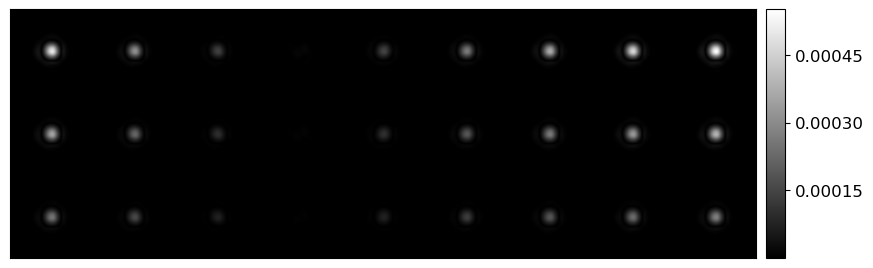

In [21]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [22]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [23]:
# plt.savefig(os.path.join(filepath, 'reconstruction_idea.png'), dpi=1200, transparent=True)